In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint        # for saving models
from tensorflow.keras.losses import MeanSquaredError          # loss function
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
coupling=2.11                               # Coupling value of Kuramoto model network
num_nodes = 1000
window_sizes = [5,10,20]                # List of window sizes to be used for training
n_epochs= 30                               # Number of epochs for training
model_name = "FCN"

In [3]:
# Load the data
data = np.load(f'./Data/Degree_Radian=1.57_copling={coupling}layer2(time)VS(Node).npz')

print("Available arrays in the .npz file:", data.files)
array_key = data.files[0]                                       # Takes the first array
print(f"Using array: {array_key}")

scale_factor = 100  
array_data = data[array_key].astype(np.float32) / scale_factor

df = pd.DataFrame(array_data)
df.columns = [f'theta{i+1}' for i in range(len(df.columns))]    # Rename columns

Available arrays in the .npz file: ['phases']
Using array: phases


In [4]:
df

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,...,theta991,theta992,theta993,theta994,theta995,theta996,theta997,theta998,theta999,theta1000
0,5.03,5.62,5.56,4.44,5.75,5.69,4.70,4.17,4.40,4.82,...,2.98,2.87,4.43,2.63,4.66,5.51,0.22,4.36,5.22,2.25
1,5.11,5.74,5.68,4.53,5.86,5.80,4.78,4.25,4.49,4.87,...,2.99,2.87,4.50,2.61,4.65,5.45,0.14,4.31,5.21,2.22
2,5.18,5.85,5.79,4.62,5.97,5.91,4.87,4.34,4.57,4.92,...,2.99,2.86,4.57,2.59,4.64,5.39,0.06,4.26,5.19,2.18
3,5.26,5.97,5.91,4.72,6.09,6.03,4.95,4.43,4.66,4.98,...,2.98,2.85,4.64,2.57,4.64,5.33,6.27,4.21,5.18,2.14
4,5.34,6.08,6.02,4.81,6.20,6.14,5.04,4.52,4.74,5.04,...,2.97,2.83,4.71,2.54,4.63,5.28,6.20,4.15,5.17,2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2.99,3.24,4.54,5.05,4.97,5.01,5.03,5.19,5.24,5.25,...,0.46,0.82,2.56,2.47,2.64,5.24,5.47,5.48,5.47,5.42
29996,2.96,3.22,4.59,5.12,5.04,5.08,5.11,5.27,5.32,5.33,...,0.45,0.75,2.52,2.43,2.60,5.34,5.53,5.54,5.54,5.52
29997,2.94,3.21,4.65,5.20,5.12,5.16,5.18,5.35,5.40,5.41,...,0.44,0.69,2.47,2.39,2.56,5.44,5.59,5.61,5.62,5.63
29998,2.90,3.18,4.70,5.27,5.19,5.23,5.26,5.43,5.48,5.50,...,0.44,0.63,2.43,2.34,2.51,5.54,5.66,5.67,5.70,5.73


In [5]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i + window_size])           # shape: (window_size, n_features)
        y.append(df_as_np[i + window_size])             # shape: (n_features,)
    return np.array(X), np.array(y)

In [ ]:
def ann(num_nodes, window_size, model_name):
    input_layer = Input(shape=(window_size, num_nodes), dtype=tf.float32)

    # Apply cosine and sine element-wise
    cos_layer = Lambda(lambda x: tf.math.cos(x))(input_layer)
    sin_layer = Lambda(lambda x: tf.math.sin(x))(input_layer)
    x = Concatenate(axis=-1)([cos_layer, sin_layer])  # Shape: (window_size, 2*num_features)

    if model_name == "FCN":
        x = Flatten()(x)
        x = Dense(512, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        #x = Dense(1280, activation='relu')(x)

    elif model_name == "LSTM": 
        x = LSTM(128)(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
   
    output = tf.keras.layers.Dense(num_nodes, activation='linear')(x)
        
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model

In [7]:
def create_and_train_model(model_name, window_size, epochs):
    # Make inputs and actual labels of them
    X, y = df_to_X_y(df, window_size)
    # Split train and test data
    X_train, y_train = X[:20000], y[:20000]
    X_val, y_val = X[20000:25000], y[20000:25000]
    X_test, y_test = X[25000:], y[25000:]
    print("Train:", X_train.shape, y_train.shape)
    print("Val:", X_val.shape, y_val.shape)
    print("Test:", X_test.shape, y_test.shape)
    num_nodes = X.shape[2]
    print("num_nodes = ", X.shape[1])

    model = ann(num_nodes,window_size, model_name)
    model.summary()
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
    '''
    # Saving model
    model_filename = f'./Results/model_LSTM_hidden6400_J={coupling}_window{window_size}.keras'
    model.save(model_filename)'''

    # Make predictions
    predictions = model.predict(X_test)
    print(predictions)
    
    os.makedirs("./Results", exist_ok=True)
    np.savetxt(f"./Results/J={coupling}_window{window_size}_actual.txt", y_test, fmt='%.2f', delimiter='\t', newline='\n', encoding=None)
    np.savetxt(f"./Results/J={coupling}_window{window_size}_predicted.txt", predictions, fmt='%.2f', delimiter='\t', newline='\n', encoding=None)

    return history, predictions

In [8]:
# Dictionary to store training histories for each window size
histories = {}

for window_size in window_sizes:
    print(f"Training model with window size: {window_size}")
    history,_ = create_and_train_model(model_name, window_size, n_epochs)   # Create and train the model with the current window size
    histories[window_size] = history    

Training model with window size: 5
Train: (20000, 5, 1000) (20000, 1000)
Val: (5000, 5, 1000) (5000, 1000)
Test: (4995, 5, 1000) (4995, 1000)
num_nodes =  5



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 1000)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5, 1000)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 5, 1000)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 2000)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10000)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  1,280,128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1000)      │    129,000 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,442,152 (5.50 MB)

 Trainable params: 1,442,152 (5.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 4.5769 - root_mean_squared_error: 2.0686 - val_loss: 1.4167 - val_root_mean_squared_error: 1.1903
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 1.3821 - root_mean_squared_error: 1.1756 - val_loss: 1.3201 - val_root_mean_squared_error: 1.1490
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 1.2844 - root_mean_squared_error: 1.1333 - val_loss: 1.2648 - val_root_mean_squared_error: 1.1246
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 1.2171 - root_mean_squared_error: 1.1032 - val_loss: 1.2207 - val_root_mean_squared_error: 1.1048
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 1.1786 - root_mean_squared_error: 1.0856 - val_loss: 1.1890 - val_root_mean_squared_error: 1.0904
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 1.1238 - root_mean_squared_error: 1.0601 - val_loss: 1.1709 - val_root_mean_squared_error: 1.0821
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 1000)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 10, 1000)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 10, 1000)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10, 2000)  │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20000)     │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  2,560,128 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1000)      │    129,000 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,722,152 (10.38 MB)

 Trainable params: 2,722,152 (10.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - loss: 4.5298 - root_mean_squared_error: 2.0570 - val_loss: 1.4195 - val_root_mean_squared_error: 1.1914
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 1.3852 - root_mean_squared_error: 1.1769 - val_loss: 1.3358 - val_root_mean_squared_error: 1.1558
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 1.2959 - root_mean_squared_error: 1.1383 - val_loss: 1.2730 - val_root_mean_squared_error: 1.1283
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 1.2275 - root_mean_squared_error: 1.1079 - val_loss: 1.2326 - val_root_mean_squared_error: 1.1102
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 1.1821 - root_mean_squared_error: 1.0872 - val_loss: 1.2010 - val_root_mean_squared_error: 1.0959
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - loss: 1.1243 - root_mean_squared_error: 1.0603 - val_loss: 1.1723 - val_root_mean_squared_error: 1.0827
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 

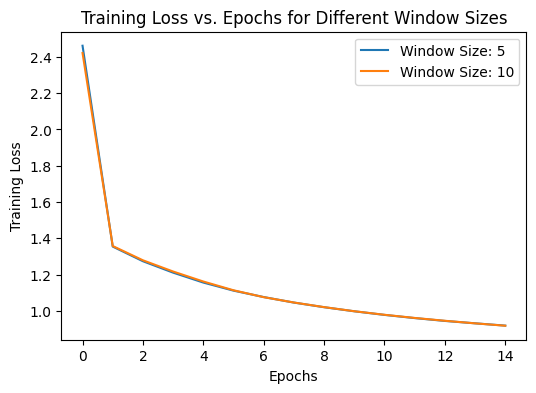

In [9]:
plt.figure(figsize=(6, 4))

for window_size, history in histories.items():
    plt.plot(history.history['loss'], label=f'Window Size: {window_size}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for Different Window Sizes')
plt.legend()
plt.savefig(f'./Results/training_loss_vs_epochs_J={coupling}.png')
plt.show()

In [ ]:
def plot_results(window_size):


    # Define the colors for the custom cyclic colormap
    colors = [
        (1.0, 0.0, 1.0),  # Magenta (255, 0, 255)
        (1.0, 0.0, 0.0),  # Red (255, 0, 0)
        (1.0, 1.0, 0.0),  # Yellow (255, 255, 0)
        (0.0, 1.0, 0.0),  # Green (0, 255, 0)
        (0.0, 1.0, 1.0),  # Cyan (0, 255, 255)
        (0.0, 0.0, 1.0),  # Blue (0, 0, 255)
        (1.0, 0.0, 1.0)   # Magenta (255, 0, 255)
    ]

    # Create the custom cyclic colormap
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    fig = plt.figure()

    # _________________________________________________________
    ax_1 = plt.subplot(3, 4, (1, 4))
    # Read the input data
    with open(f"./Results/J={coupling}_window{window_size}_actual.txt") as textFile:  # ./Results/J={coupling}_actual.txt
        lines = [line.split() for line in textFile]
    lines = np.array(lines, dtype=float).transpose()  # Convert to numpy array and transpose


    # Subtract 2*pi from values greater than pi
    #lines = np.where(lines > np.pi, lines - 2 * np.pi, lines)
    # Add 2*pi to values less than -pi
    #lines = np.where(lines < -np.pi, lines + 2 * np.pi, lines)

    print(np.min(lines))
    print(np.max(lines))


    # plot
    vmin = 0
    vmax = 2*np.pi
    plt.imshow(lines, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    #cbar.ax.set_yticklabels(['-π', '0', 'π'])

    plt.title(f'Comparision (window {window_size})', fontsize=10)

    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines[0]))
    plt.ylim(0, num_nodes)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________

    ax_2 = plt.subplot(3, 4, (5, 8))

    # Read the input data
    with open(f"./Results/J={coupling}_window{window_size}_predicted.txt") as textFile:
        lines2 = [line.split() for line in textFile]
    lines2 = np.array(lines2, dtype=float).transpose()  # Convert to numpy array and transpose

    # Subtract 2*pi from values greater than pi
    lines2 = np.where(lines2 > 2*np.pi, lines2 - 2 * np.pi, lines2)
    # Add 2*pi to values less than -pi
    lines2 = np.where(lines2 < 0, lines2 + 2 * np.pi, lines2)

    print(np.min(lines2))
    print(np.max(lines2))
    # plot
    vmin = 0
    vmax = 2*np.pi
    plt.imshow(lines2, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    #cbar.ax.set_yticklabels(['-π', '0', 'π'])

    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines2[0]))
    plt.ylim(0, num_nodes)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________
    def kuramoto_similarity(theta1, theta2):
        z1 = np.exp(1j * theta1)
        z2 = np.exp(1j * theta2)
        return np.abs((z1 + z2) / 2)


    '''def phase_similarity(theta1, theta2):
        delta = np.angle(np.exp(1j * (theta1 - theta2)))  # in range [-π, π]
        distance = np.abs(delta)  # in range [0, π]
        similarity = 1 - (distance / np.pi)  # normalize to [0, 1]
        return similarity'''
    s = (len(lines[:, 0]),len(lines[0, :]))
    lines3 = np.zeros(s)
    ax_3 = plt.subplot(3, 4, (9, 12))
    for i in range(lines.shape[0]):
        for j in range(lines.shape[1]):
            lines3[i][j] = kuramoto_similarity(lines2[i][j] ,lines[i][j])

    print(np.min(lines3))
    print(np.max(lines3))
    # plot
    plt.imshow(lines3, cmap='binary', aspect='auto', interpolation='nearest')
    cbar = plt.colorbar(ticks=[-1.001, 0, 1])
    # cbar.ax.set_yticklabels(['-1', '0', '1'])
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines3[0]))
    print(len(lines3[0]))
    plt.ylim(0, num_nodes)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # Save the figure as a .png file
    plt.subplots_adjust(top=0.97, bottom=0.08, hspace=0.3, wspace=0.44)


    plt.gcf().set_size_inches(12, 3)
    #plt.savefig(f'/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/result_J={coupling}_window{window_size}.pdf')
    plt.savefig(f'./Results/result_J={coupling}_window{window_size}.png' , dpi=300)

0.0
6.28
0.0
6.28
0.0007963267107329056
1.0000000000000002
4995
0.0
6.28
0.0
6.28
0.000796326710732884
1.0000000000000002
4950


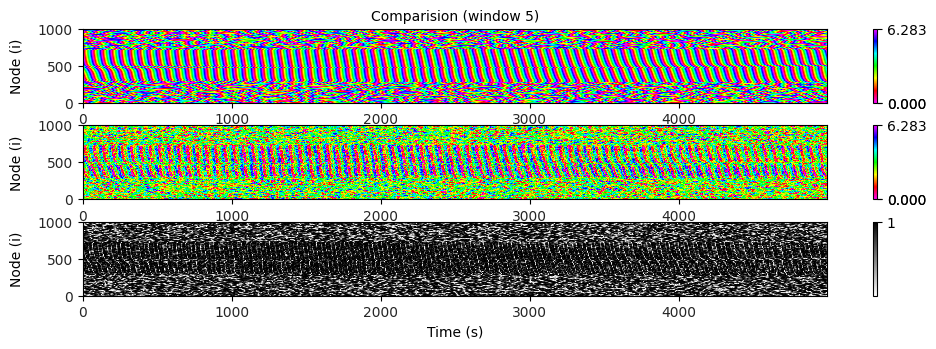

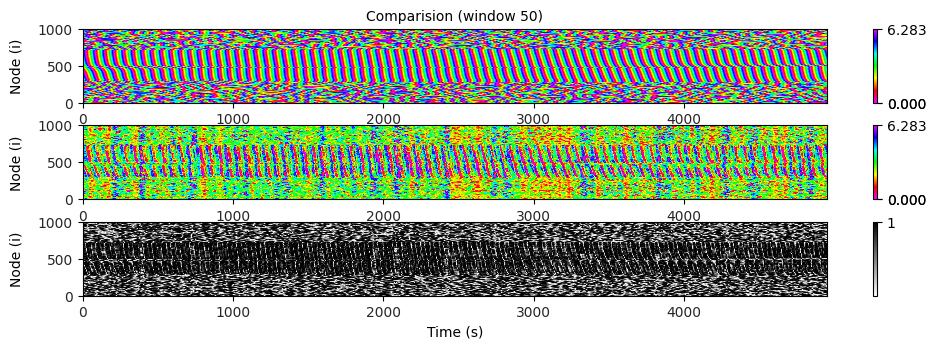

In [6]:
for window_size in window_sizes:
    plot_results(window_size)